In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
# %run ../Jane/extract_data.py

Your data is ready! Merged table name is zillow_full.


## Importing previously imputed data

In [184]:
# zillow_data = pd.read_csv('../../data/zillow_full_imputed.csv',dtype={'Zipcode':str})
# zillow_data = zillow_full.copy()
zillow_data = pd.read_csv('../../data/ZillowMarch26.csv',dtype={'Zipcode':str})
zillow_data['Date'] = pd.to_datetime(zillow_data['Date'])

In [185]:
zillow_data.set_index('Date',inplace = True)

In [186]:
zillow_data.shape

(17751, 25)

In [187]:
zillow_data.dtypes

Zipcode                  object
City                     object
State                    object
Metro                    object
County                   object
SizeRank                  int64
Rent                    float64
Year                      int64
State-County             object
total_pop               float64
households              float64
median_age              float64
median_income           float64
income_per_capita       float64
gini_index              float64
pct_poverty             float64
housing_availability    float64
home_density            float64
pct_employed            float64
pct_jobs_nightlife      float64
pct_unemployed          float64
move_within_city        float64
move_new_city           float64
avg_commute_time        float64
pct_college             float64
dtype: object

In [188]:
zillow_data.isnull().sum()

Zipcode                 0
City                    0
State                   0
Metro                   0
County                  0
SizeRank                0
Rent                    0
Year                    0
State-County            0
total_pop               0
households              0
median_age              0
median_income           0
income_per_capita       0
gini_index              0
pct_poverty             0
housing_availability    0
home_density            0
pct_employed            0
pct_jobs_nightlife      0
pct_unemployed          0
move_within_city        0
move_new_city           0
avg_commute_time        0
pct_college             0
dtype: int64

## Random Forest regressor

In [189]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [190]:
LE = LabelEncoder()
ss = StandardScaler()
features = zillow_data.drop(['Rent','State-County','State','Year',
                             'City','Metro','County','Zipcode','SizeRank'],axis = 1)
y = np.log(zillow_data['Rent'])

In [9]:

# features['Zipcode'] = features['Zipcode'].astype(int)

In [191]:
cat_cols = features.select_dtypes(include = object).copy()
num_cols = features.select_dtypes(exclude = object).copy()

In [192]:
for col in cat_cols.columns:
    cat_cols[col] = LE.fit_transform(cat_cols[col])

X = pd.concat([cat_cols,num_cols],axis = 1)

In [193]:
X.shape

(17751, 16)

In [194]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators = 500)

In [195]:
print(X.index[0])
print(X.index[-1])

2015-01-01 00:00:00
2020-01-01 00:00:00


In [196]:
X.columns

Index(['total_pop', 'households', 'median_age', 'median_income',
       'income_per_capita', 'gini_index', 'pct_poverty',
       'housing_availability', 'home_density', 'pct_employed',
       'pct_jobs_nightlife', 'pct_unemployed', 'move_within_city',
       'move_new_city', 'avg_commute_time', 'pct_college'],
      dtype='object')

0.7049180327868853


In [203]:
#splitting train/test sets before/after 2019
Xtrain = X.loc[X.index <'2018-08-01']
train_index = Xtrain.shape[0]
Xtest = X[train_index:]
ytrain = y[:train_index]
ytest = y[train_index:]


In [204]:
rfc.fit(Xtrain,ytrain)

RandomForestRegressor(n_estimators=500)

In [205]:
rfc.score(Xtrain,ytrain)

0.9766264927615496

In [206]:
rfc.score(Xtest,ytest)

0.9468638720284546

In [207]:
rfc.feature_importances_

array([0.0053538 , 0.00500555, 0.03538983, 0.27479373, 0.18073645,
       0.04667346, 0.02462004, 0.0600326 , 0.01824313, 0.02555907,
       0.01397284, 0.01521965, 0.02708912, 0.05103866, 0.13739386,
       0.0788782 ])

In [208]:
rfc_imp = pd.DataFrame({'Columns':X.columns,'Feature_importances':rfc.feature_importances_})

In [209]:
rfc_imp.sort_values(by = 'Feature_importances',ascending = False)

,Columns,Feature_importances
3,median_income,0.274794
4,income_per_capita,0.180736
14,avg_commute_time,0.137394
15,pct_college,0.078878
7,housing_availability,0.060033
13,move_new_city,0.051039
5,gini_index,0.046673
2,median_age,0.035390
12,move_within_city,0.027089
9,pct_employed,0.025559


In [210]:
ypred = rfc.predict(Xtest)

In [211]:
from sklearn.metrics import mean_squared_error

In [212]:
RMSE = mean_squared_error(np.exp(ytest),np.exp(ypred), squared = False)
print(f'RMSE: {round(RMSE,2)}')


def abs_relative_error(ytest,ypred,df):
    '''returns a plot of the metro area rent errors relative to the rent price
    
    Args:
    
    ytest: pd.DataFrame, Actual rent values
    ypred: np.array, predicted rent values
    df: pd.DataFrame'''
    abs_pct_rent_error = pd.Series(np.abs((np.exp(ytest)-np.exp(ypred))/np.exp(ytest)))

    test_metros = df['Metro'].loc[df.index >=ytest.index[0]].copy()

    test_predictions = pd.concat([abs_pct_rent_error,test_metros],axis = 1)
    test_predictions.reset_index(inplace = True)
    data_error_max = test_predictions.groupby(['Date','Metro'],as_index = False)['Rent'].mean()

    fig = plt.figure(figsize =(15,10))
    sns.lineplot(data = data_error_max, x = 'Date', y = 'Rent',hue = 'Metro')
    plt.title('Mean absolute error as percentage of rent')
    plt.xlabel('Date')
    plt.ylabel('Error in percent of actual rent')
    plt.legend(loc = 'upper left')
    

RMSE: 136.18


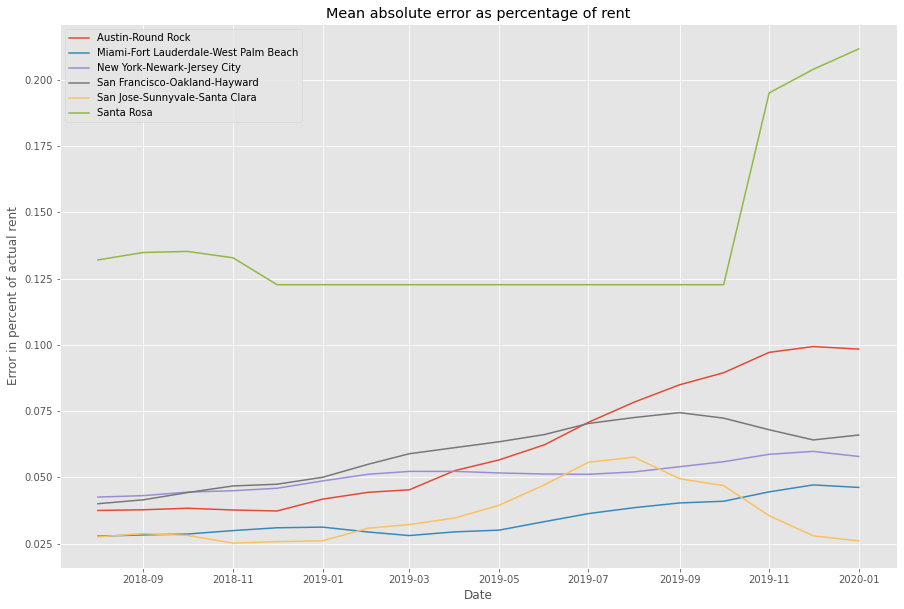

In [214]:
abs_relative_error(ytest,ypred,zillow_data)

In [95]:
from sklearn.model_selection import GridSearchCV
estimators= list(map(int,np.linspace(400,700,4)))
param_grid = {'n_estimators':estimators}

estimators

[400, 500, 600, 700]

In [96]:
grid = GridSearchCV(RandomForestRegressor(),param_grid = param_grid)

In [97]:
grid.fit(Xtrain,ytrain)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [400, 500, 600, 700]})

In [98]:
grid.best_params_

{'n_estimators': 500}

In [215]:
grid.score(Xtest,ytest)

0.9544701309653977

In [100]:
grid.best_score_

0.965529959472095

In [216]:
y_pred = grid.predict(Xtest)
print(mean_squared_error(np.exp(ytest),np.exp(ypred),squared = False))

136.17970917487006


In [217]:
rfc.set_params(**grid.best_params_)

RandomForestRegressor(n_estimators=500)

In [218]:
rfc.fit(Xtrain,ytrain)

RandomForestRegressor(n_estimators=500)

In [104]:
rfc.score(Xtest,ytest)

0.9475477911148783

In [219]:
rfc_imp = pd.DataFrame({'Columns':X.columns,'Feature_importances':rfc.feature_importances_})

rfc_imp.sort_values(by = 'Feature_importances',ascending = False)

,Columns,Feature_importances
3,median_income,0.275983
4,income_per_capita,0.178989
14,avg_commute_time,0.137277
15,pct_college,0.078873
7,housing_availability,0.061771
13,move_new_city,0.050976
5,gini_index,0.048103
2,median_age,0.034787
9,pct_employed,0.026790
12,move_within_city,0.026166


## Writing CV to preserve time-series structure

In [224]:
X.columns

Index(['total_pop', 'households', 'median_age', 'median_income',
       'income_per_capita', 'gini_index', 'pct_poverty',
       'housing_availability', 'home_density', 'pct_employed',
       'pct_jobs_nightlife', 'pct_unemployed', 'move_within_city',
       'move_new_city', 'avg_commute_time', 'pct_college'],
      dtype='object')

In [39]:
import seaborn as sns

<AxesSubplot:>

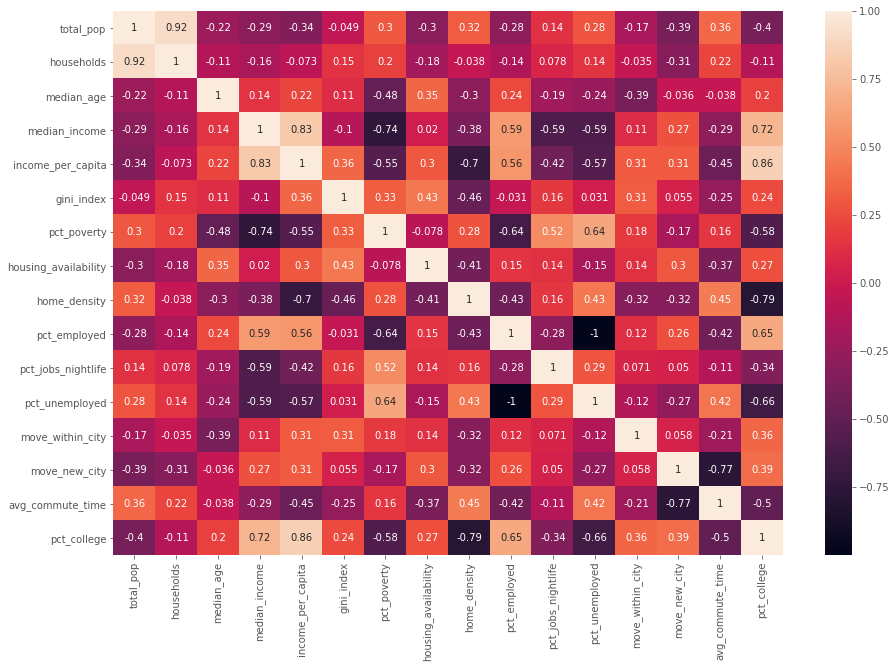

In [222]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize = (15,10))
sns.heatmap(X.corr(),annot = True)


In [230]:
rent_dates = X.index.unique()

train_end = 9
test_start = train_end
test_end = test_start +3

cv_dict = {'train_score':[],
              'test_score':[],
              'RMSE':[]}

predictions = []
rfc_cv = RandomForestRegressor()
rfc_cv.set_params(n_estimators = 600)

while test_end <=len(rent_dates):


    Xtrain = X[X.index.isin(rent_dates[:train_end])]
    ytrain = y[y.index.isin(rent_dates[:train_end])]
    Xtest = X[X.index.isin(rent_dates[test_start:test_end])]
    ytest = y[y.index.isin(rent_dates[test_start:test_end])]
    rfc_cv.fit(Xtrain,ytrain)
    cv_dict['train_score'].append(rfc_cv.score(Xtrain,ytrain))
    cv_dict['test_score'].append(rfc_cv.score(Xtest,ytest))
    cv_pred = rfc_cv.predict(Xtest)
    predictions.extend(cv_pred)
    cv_dict['RMSE'].append(mean_squared_error(np.exp(ytest),np.exp(cv_pred),squared = False))
    
    print(f'Training date range: {Xtrain.index.unique().tolist()[0]} : {Xtrain.index.unique().tolist()[-1]}')
    print(f'Testing date range: {Xtest.index.unique().tolist()[0]} : {Xtest.index.unique().tolist()[-1]}')
    print(f'Random forest test score: {rfc_cv.score(Xtest,ytest)}\n')
    train_end +=3
    test_start +=3
    test_end +=3

Training date range: 2015-01-01 00:00:00 : 2015-09-01 00:00:00
Testing date range: 2015-10-01 00:00:00 : 2015-12-01 00:00:00
Random forest test score: 0.9673849073730199

Training date range: 2015-01-01 00:00:00 : 2015-12-01 00:00:00
Testing date range: 2016-01-01 00:00:00 : 2016-03-01 00:00:00
Random forest test score: 0.9673429730166465

Training date range: 2015-01-01 00:00:00 : 2016-03-01 00:00:00
Testing date range: 2016-04-01 00:00:00 : 2016-06-01 00:00:00
Random forest test score: 0.9638005021021144

Training date range: 2015-01-01 00:00:00 : 2016-06-01 00:00:00
Testing date range: 2016-07-01 00:00:00 : 2016-09-01 00:00:00
Random forest test score: 0.9575674807746432

Training date range: 2015-01-01 00:00:00 : 2016-09-01 00:00:00
Testing date range: 2016-10-01 00:00:00 : 2016-12-01 00:00:00
Random forest test score: 0.9544134059557684

Training date range: 2015-01-01 00:00:00 : 2016-12-01 00:00:00
Testing date range: 2017-01-01 00:00:00 : 2017-03-01 00:00:00
Random forest test s

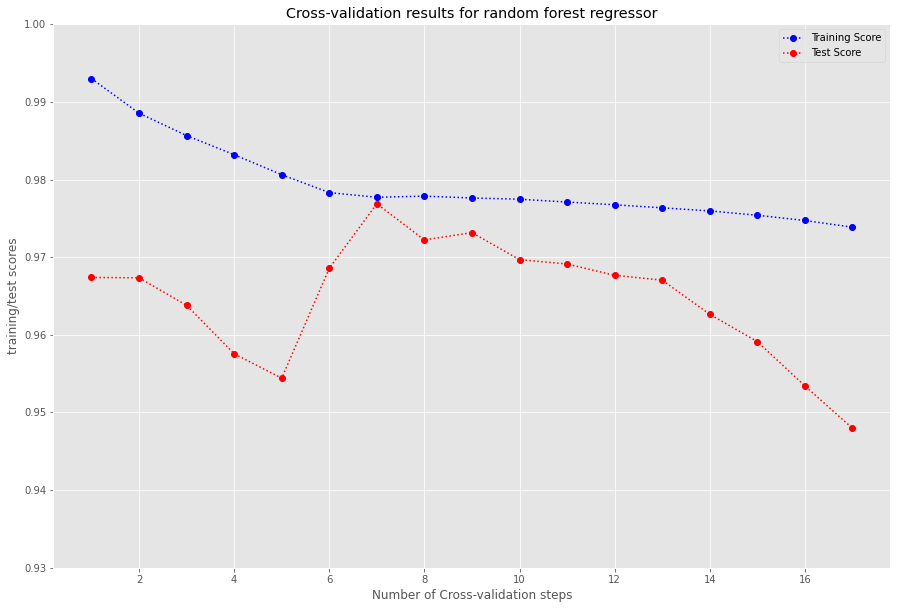

In [241]:
import matplotlib.pyplot as plt
cv_results = pd.DataFrame(cv_dict)
cv_results.index = cv_results.index +1
plt.figure(figsize = (15,10))
plt.plot(cv_results['train_score'],'bo:')
plt.plot(cv_results['test_score'],'ro:')
plt.legend(['Training Score','Test Score'])
plt.xlabel('Number of cross-validation steps')
plt.ylabel('training/test scores')
plt.title('Cross-validation results for random forest regressor')
plt.ylim([.93,1])
plt.show()


In [242]:
print(cv_results['test_score'].mean())
print(cv_results.shape[0])

0.9645892713007539
17


Text(0.5, 1.0, 'Cross-validation results for random forest regressor')

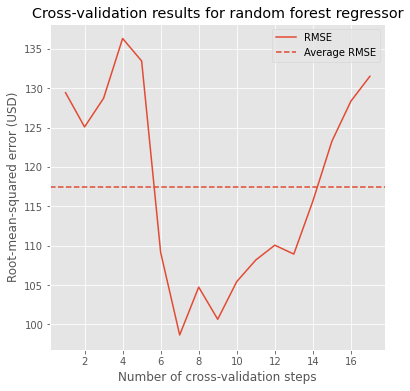

In [250]:
plt.figure(figsize = (6,6))
plt.plot(cv_results['RMSE'])
plt.xlabel('Number of cross-validation steps')
plt.ylabel('Root-mean-squared error (USD)')
plt.axhline(np.mean(cv_results['RMSE']),ls = '--')
plt.legend(['RMSE','Average RMSE'])
plt.title('Cross-validation results for random forest regressor')

In [82]:
Xtest.shape

(873, 19)

In [237]:
cv_results.index = cv_results.index+1

In [238]:
cv_results

,train_score,test_score,RMSE
1,0.992996,0.967385,129.419775
2,0.988540,0.967343,125.072728
3,0.985659,0.963801,128.718438
4,0.983195,0.957567,136.306194
5,0.980622,0.954413,133.444783
6,0.978315,0.968575,109.139443
7,0.977711,0.976874,98.662811
8,0.977862,0.972219,104.740005
9,0.977622,0.973163,100.654063
10,0.977462,0.969681,105.440520
